Series de Tiempo para el análisis de Nuevos Contagios en Argentina

Comenzamos importando las distintas librerías que nos serán útiles a lo largo de la notebook:

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [6]:
df=pd.read_csv("owid-covid-data.csv")

Observamos cómo está compuesto el dataset:

In [7]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [8]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [9]:
df.dtypes

iso_code                                  object
continent                                 object
location                                  object
date                                      object
total_cases                              float64
new_cases                                float64
new_cases_smoothed                       float64
total_deaths                             float64
new_deaths                               float64
new_deaths_smoothed                      float64
total_cases_per_million                  float64
new_cases_per_million                    float64
new_cases_smoothed_per_million           float64
total_deaths_per_million                 float64
new_deaths_per_million                   float64
new_deaths_smoothed_per_million          float64
reproduction_rate                        float64
icu_patients                             float64
icu_patients_per_million                 float64
hosp_patients                            float64
hosp_patients_per_mi

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73384 entries, 0 to 73383
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               73384 non-null  object 
 1   continent                              69750 non-null  object 
 2   location                               73384 non-null  object 
 3   date                                   73384 non-null  object 
 4   total_cases                            72326 non-null  float64
 5   new_cases                              72324 non-null  float64
 6   new_cases_smoothed                     71323 non-null  float64
 7   total_deaths                           63170 non-null  float64
 8   new_deaths                             63328 non-null  float64
 9   new_deaths_smoothed                    71323 non-null  float64
 10  total_cases_per_million                71931 non-null  float64
 11  ne

In [11]:
df["continent"].value_counts()

Africa           19274
Europe           17728
Asia             17523
North America     8660
South America     4476
Oceania           2089
Name: continent, dtype: int64

In [12]:
df.shape

(73384, 59)

Cambiamos el formato de la columna Date a datetime y la renombramos como "fecha" para poder trabajarla más adelante:

In [13]:
df['fecha'] = pd.to_datetime(df['date'])

In [14]:
df.shape

(73384, 60)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73384 entries, 0 to 73383
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   iso_code                               73384 non-null  object        
 1   continent                              69750 non-null  object        
 2   location                               73384 non-null  object        
 3   date                                   73384 non-null  object        
 4   total_cases                            72326 non-null  float64       
 5   new_cases                              72324 non-null  float64       
 6   new_cases_smoothed                     71323 non-null  float64       
 7   total_deaths                           63170 non-null  float64       
 8   new_deaths                             63328 non-null  float64       
 9   new_deaths_smoothed                    71323 non-null  float6

Una vez hecho esto realizamos una máscara poder filtrar a Argentina de entre todos los países del mundo:


In [17]:


mask_arg = df["location"] == "Argentina"
df_arg = df[mask_arg]
df_arg.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,fecha
2628,ARG,South America,Argentina,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,0.000,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.5,16.2,27.7,NaN,5.0,76.67,0.845,2020-01-01
2629,ARG,South America,Argentina,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,47.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.5,16.2,27.7,NaN,5.0,76.67,0.845,2020-01-02
2630,ARG,South America,Argentina,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,51.0,0.001,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.5,16.2,27.7,NaN,5.0,76.67,0.845,2020-01-03
2631,ARG,South America,Argentina,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,68.0,0.002,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.5,16.2,27.7,NaN,5.0,76.67,0.845,2020-01-04
2632,ARG,South America,Argentina,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,78.0,0.002,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.5,16.2,27.7,NaN,5.0,76.67,0.845,2020-01-05


Creamos un dataset que se llama "Arg" que sólo contendrá algunas columnas. Las que se utilizarán en esta notebook serán en su mayoría: "fecha" y "new_cases_smoothed" que muestran los nuevos contagios día  a día:

In [18]:
Arg=df_arg[['fecha','new_cases_smoothed', 'new_vaccinations', 'new_deaths', 'new_tests']]
Arg.head(20)

,fecha,new_cases_smoothed,new_vaccinations,new_deaths,new_tests
2628,2020-01-01,NaN,NaN,NaN,4.0
2629,2020-01-02,NaN,NaN,NaN,43.0
2630,2020-01-03,NaN,NaN,NaN,4.0
2631,2020-01-04,NaN,NaN,NaN,17.0
2632,2020-01-05,NaN,NaN,NaN,10.0
2633,2020-01-06,NaN,NaN,NaN,53.0
2634,2020-01-07,NaN,NaN,NaN,28.0
2635,2020-01-08,NaN,NaN,NaN,5.0
2636,2020-01-09,NaN,NaN,NaN,1.0
2637,2020-01-10,NaN,NaN,NaN,76.0


In [19]:
Arg.shape

(432, 5)

In [20]:
Arg.isnull().sum()

fecha                   0
new_cases_smoothed     67
new_vaccinations      394
new_deaths             67
new_tests              25
dtype: int64

Ahora reemplazamos a los valores nulos por ceros, debido a que los casos nulos previos al covid implican que no hubo casos en ese período:

In [21]:
Arg.fillna(value=0)

,fecha,new_cases_smoothed,new_vaccinations,new_deaths,new_tests
2628,2020-01-01,0.000,0.0,0.0,4.0
2629,2020-01-02,0.000,0.0,0.0,43.0
2630,2020-01-03,0.000,0.0,0.0,4.0
2631,2020-01-04,0.000,0.0,0.0,17.0
2632,2020-01-05,0.000,0.0,0.0,10.0
...,...,...,...,...,...
3055,2021-03-03,5874.286,55184.0,261.0,0.0
3056,2021-03-04,5759.714,71169.0,191.0,0.0
3057,2021-03-05,6160.857,105135.0,140.0,0.0
3058,2021-03-06,6073.857,0.0,86.0,0.0


Ahora graficamos la evolución de nuevos casos en el país desde marzo 2020 hasta marzo 2021:

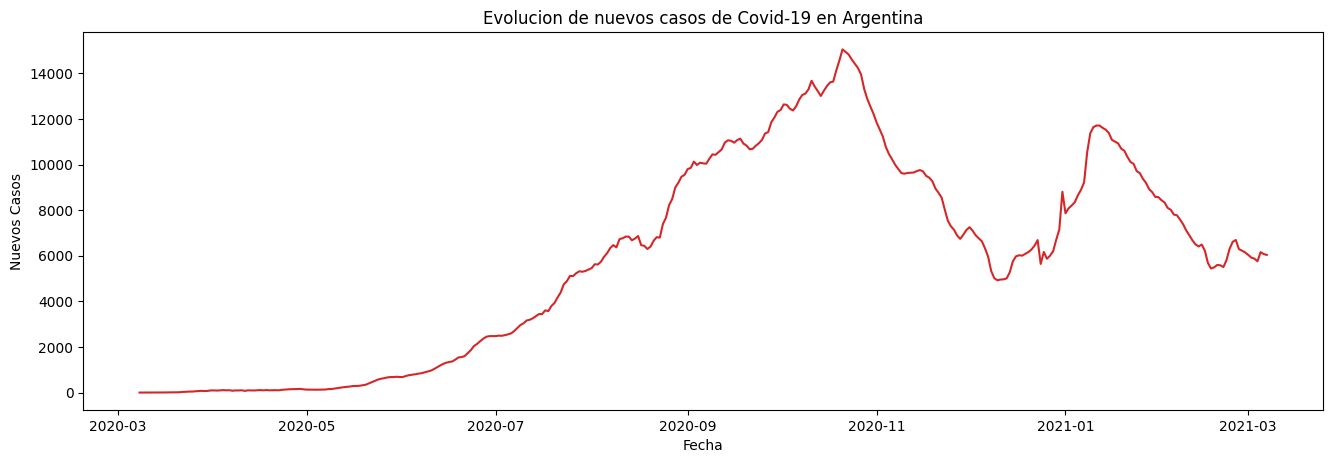

In [22]:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Nuevos Casos', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=Arg.fecha, y=Arg.new_cases_smoothed,\
        title='Evolucion de nuevos casos de Covid-19 en Argentina')

Ahora preparamos algunas variables para poder evaluar su estacionalidad y tendencia más adelante:

In [23]:

Arg['year'] = [d.year for d in Arg.fecha]
# Arg['year']
Arg['month'] = [d.strftime('%b') for d in Arg.fecha]
# Arg['month']
years = Arg['year'].unique()
years

array([2020, 2021])

In [24]:

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

Graficamos tanto tendencia como estacionalidad (teniendo en cuenta a 2020 y 2021, y después sólo teniendo en cuenta a 2020):

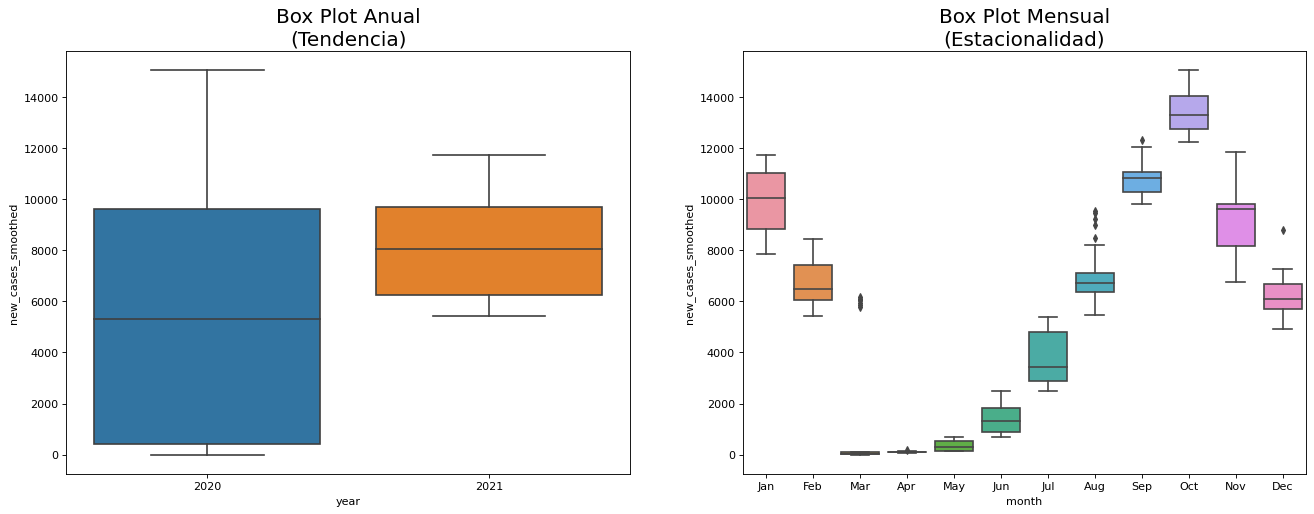

In [25]:

fig, axes = plt.subplots(1, 2,  figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='new_cases_smoothed', data=Arg, ax=axes[0])
sns.boxplot(x='month', y='new_cases_smoothed', data=Arg.loc[Arg.year.isin([2020,2021]), :])

axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18);

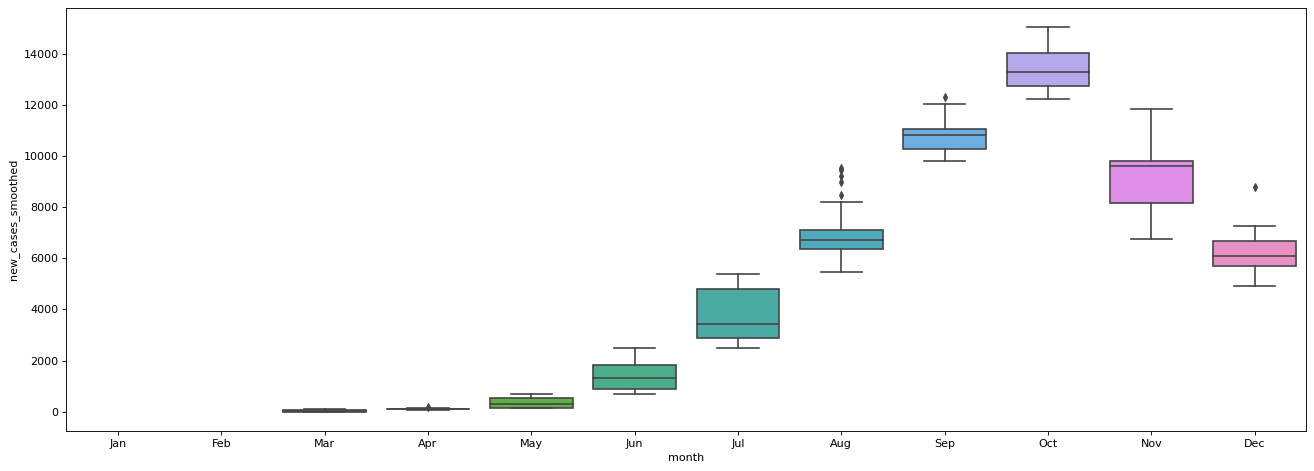

In [26]:
# Definimos los plots:
fig, axes = plt.subplots(1,  figsize=(20,7), dpi= 80)
sns.boxplot(x='month', y='new_cases_smoothed', data=Arg.loc[Arg.year.isin([2020]), :])

Como podemos observar, la tendencia solo consta de 2 años ya que los datos comenzaron a registrarse a partir de comienzos de 2020. Por otra parte, la estacionalidad en los primeros meses varía marcadamente año a año ya que el contexto mismo cambia (en un caso había cuarentena y en otro no).

In [27]:
Arg["timeIndex"] = pd.Series(np.arange(len(Arg['new_cases_smoothed'])), index=Arg.index)
Arg["timeIndex_sq"] = Arg["timeIndex"]**2
Arg["timeIndex"]

2628      0
2629      1
2630      2
2631      3
2632      4
       ... 
3055    427
3056    428
3057    429
3058    430
3059    431
Name: timeIndex, Length: 432, dtype: int64

Creamos variables dummies para cada mes del año:

In [28]:
dummies_mes = pd.get_dummies(Arg['month'], drop_first=True)
dummies_mes.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
2628,0,0,0,1,0,0,0,0,0,0,0
2629,0,0,0,1,0,0,0,0,0,0,0
2630,0,0,0,1,0,0,0,0,0,0,0
2631,0,0,0,1,0,0,0,0,0,0,0
2632,0,0,0,1,0,0,0,0,0,0,0


Hacemos el join entre el DataFrame con la serie de tiempo y las dummies:

In [29]:

Arg = Arg.join(dummies_mes)
Arg.sample(10)

,fecha,new_cases_smoothed,new_vaccinations,new_deaths,new_tests,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
2961,2020-11-29,6920.143,NaN,151.0,9670.0,2020,Nov,333,110889,0,0,0,0,0,0,0,0,1,0,0
2903,2020-10-02,12636.286,NaN,311.0,30984.0,2020,Oct,275,75625,0,0,0,0,0,0,0,0,0,1,0
2944,2020-11-12,9641.571,NaN,251.0,26753.0,2020,Nov,316,99856,0,0,0,0,0,0,0,0,1,0,0
2657,2020-01-30,NaN,NaN,NaN,18.0,2020,Jan,29,841,0,0,0,1,0,0,0,0,0,0,0
2696,2020-03-09,1.714,NaN,0.0,13.0,2020,Mar,68,4624,0,0,0,0,0,0,1,0,0,0,0
2743,2020-04-25,146.000,NaN,9.0,2053.0,2020,Apr,115,13225,0,0,0,0,0,0,0,0,0,0,0
2677,2020-02-19,NaN,NaN,NaN,1.0,2020,Feb,49,2401,0,0,1,0,0,0,0,0,0,0,0
2771,2020-05-23,506.857,NaN,12.0,3991.0,2020,May,143,20449,0,0,0,0,0,0,0,1,0,0,0
2860,2020-08-20,6401.714,NaN,187.0,20765.0,2020,Aug,232,53824,1,0,0,0,0,0,0,0,0,0,0
2630,2020-01-03,NaN,NaN,NaN,4.0,2020,Jan,2,4,0,0,0,1,0,0,0,0,0,0,0


Separamos el dataset en train y test:

In [30]:
from sklearn.model_selection import train_test_split

Arg_train, Arg_test = train_test_split(Arg, test_size=12, random_state=42, shuffle=False)

In [31]:
Arg_train.tail()

,fecha,new_cases_smoothed,new_vaccinations,new_deaths,new_tests,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
3043,2021-02-19,5597.857,33071.0,143.0,43037.0,2021,Feb,415,172225,0,0,1,0,0,0,0,0,0,0,0
3044,2021-02-20,5581.714,38494.0,122.0,30978.0,2021,Feb,416,173056,0,0,1,0,0,0,0,0,0,0,0
3045,2021-02-21,5505.143,13119.0,76.0,21819.0,2021,Feb,417,173889,0,0,1,0,0,0,0,0,0,0,0
3046,2021-02-22,5813.429,1967.0,161.0,39782.0,2021,Feb,418,174724,0,0,1,0,0,0,0,0,0,0,0
3047,2021-02-23,6309.714,24381.0,151.0,39318.0,2021,Feb,419,175561,0,0,1,0,0,0,0,0,0,0,0


In [32]:
Arg_test.head()

,fecha,new_cases_smoothed,new_vaccinations,new_deaths,new_tests,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
3048,2021-02-24,6612.429,33840.0,140.0,37953.0,2021,Feb,420,176400,0,0,1,0,0,0,0,0,0,0,0
3049,2021-02-25,6692.857,49377.0,145.0,33343.0,2021,Feb,421,177241,0,0,1,0,0,0,0,0,0,0,0
3050,2021-02-26,6292.429,74083.0,92.0,35520.0,2021,Feb,422,178084,0,0,1,0,0,0,0,0,0,0,0
3051,2021-02-27,6224.571,80980.0,59.0,27224.0,2021,Feb,423,178929,0,0,1,0,0,0,0,0,0,0,0
3052,2021-02-28,6147.286,40108.0,19.0,22141.0,2021,Feb,424,179776,0,0,1,0,0,0,0,0,0,0,0


Preparamos los distintos modelos que vamos a utilizar:

Comenzamos con un modelo por la media:

In [33]:

model_mean_pred = Arg_train['new_cases_smoothed'].mean()

# La predicción es fija y es la misma para el set de testeo y de entrenamiento:
Arg_train["Mean"] = model_mean_pred
Arg_test["Mean"] = model_mean_pred


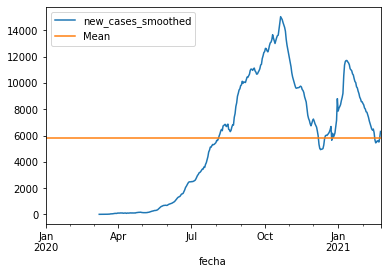

In [34]:
Arg_train.plot(kind = "line", x = "fecha", y = ['new_cases_smoothed', 'Mean']);

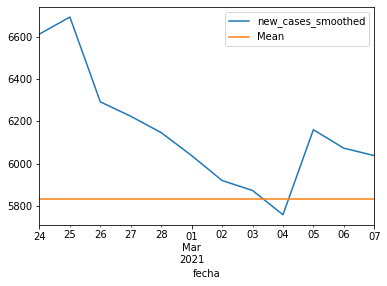

In [35]:
Arg_test.plot(kind = "line", x = "fecha", y = ['new_cases_smoothed', 'Mean']);

In [36]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [37]:
model_mean_RMSE = RMSE(Arg_test.Mean, Arg_test.new_cases_smoothed)
model_mean_RMSE

416.0958307063933

In [38]:
# Guardamos el resultado en un DataFrame:
Arg_Results = pd.DataFrame(columns = ["Model", "RMSE"])
Arg_Results.loc[0, "Model"] = "Mean"
Arg_Results.loc[0, "RMSE"] = model_mean_RMSE
Arg_Results.head()

,Model,RMSE
0,Mean,416.096


Continuamos con un modelo de Random Walk:

In [39]:
Arg_train["new_cases_smoothedShift1"] = Arg_train.new_cases_smoothed.shift()

# La primera observación nos va a quedar en nan, la reemplazamos por el valor siguente:
Arg_train["new_cases_smoothedShift1"].fillna(method='bfill', inplace=True)
Arg_train=Arg_train.fillna(value=0)

In [40]:
Arg_train.tail()

,fecha,new_cases_smoothed,new_vaccinations,new_deaths,new_tests,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mean,new_cases_smoothedShift1
3043,2021-02-19,5597.857,33071.0,143.0,43037.0,2021,Feb,415,172225,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5492.857
3044,2021-02-20,5581.714,38494.0,122.0,30978.0,2021,Feb,416,173056,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5597.857
3045,2021-02-21,5505.143,13119.0,76.0,21819.0,2021,Feb,417,173889,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5581.714
3046,2021-02-22,5813.429,1967.0,161.0,39782.0,2021,Feb,418,174724,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5505.143
3047,2021-02-23,6309.714,24381.0,151.0,39318.0,2021,Feb,419,175561,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5813.429


In [41]:

Arg_test["new_cases_smoothedShift1"] = Arg_test.new_cases_smoothed.shift()

Arg_test.head()

,fecha,new_cases_smoothed,new_vaccinations,new_deaths,new_tests,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mean,new_cases_smoothedShift1
3048,2021-02-24,6612.429,33840.0,140.0,37953.0,2021,Feb,420,176400,0,0,1,0,0,0,0,0,0,0,0,5832.668943,NaN
3049,2021-02-25,6692.857,49377.0,145.0,33343.0,2021,Feb,421,177241,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6612.429
3050,2021-02-26,6292.429,74083.0,92.0,35520.0,2021,Feb,422,178084,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6692.857
3051,2021-02-27,6224.571,80980.0,59.0,27224.0,2021,Feb,423,178929,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6292.429
3052,2021-02-28,6147.286,40108.0,19.0,22141.0,2021,Feb,424,179776,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6224.571


In [42]:
Arg_test.iloc[0,21]=Arg_test.iloc[11,21]
Arg_test.head()

,fecha,new_cases_smoothed,new_vaccinations,new_deaths,new_tests,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mean,new_cases_smoothedShift1
3048,2021-02-24,6612.429,33840.0,140.0,37953.0,2021,Feb,420,176400,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6073.857
3049,2021-02-25,6692.857,49377.0,145.0,33343.0,2021,Feb,421,177241,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6612.429
3050,2021-02-26,6292.429,74083.0,92.0,35520.0,2021,Feb,422,178084,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6692.857
3051,2021-02-27,6224.571,80980.0,59.0,27224.0,2021,Feb,423,178929,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6292.429
3052,2021-02-28,6147.286,40108.0,19.0,22141.0,2021,Feb,424,179776,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6224.571


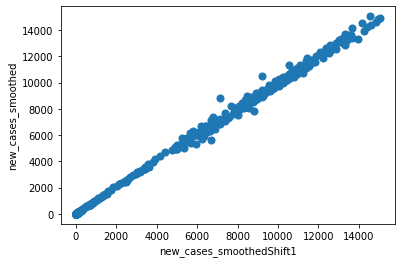

In [43]:
Arg_train.plot(kind= "scatter", y = "new_cases_smoothed", x = "new_cases_smoothedShift1", s = 50);

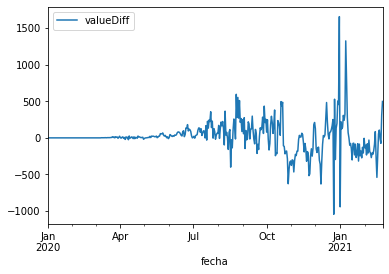

In [44]:
Arg_train["valueDiff"] = Arg_train.new_cases_smoothed - Arg_train.new_cases_smoothedShift1
Arg_train.plot(y='valueDiff', x='fecha');

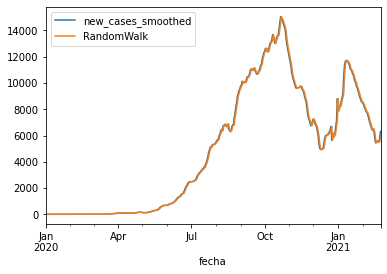

In [45]:
Arg_train["RandomWalk"] = Arg_train.new_cases_smoothedShift1
Arg_train.plot(kind="line", y = ["new_cases_smoothed", "RandomWalk"],x='fecha');

In [46]:
Arg_test["RandomWalk"] = pd.Series(Arg_train["new_cases_smoothed"].iloc[-1], index=Arg_test.index)

In [47]:
Arg_test["RandomWalk"]=pd.Series(Arg_train["new_cases_smoothed"].iloc[-1],index=Arg_test.index)
Arg_test["RandomWalk"]

3048    6309.714
3049    6309.714
3050    6309.714
3051    6309.714
3052    6309.714
3053    6309.714
3054    6309.714
3055    6309.714
3056    6309.714
3057    6309.714
3058    6309.714
3059    6309.714
Name: RandomWalk, dtype: float64

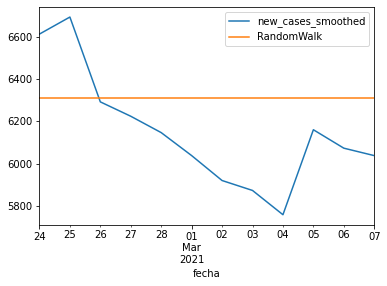

In [48]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
Arg_test.plot(kind="line", y = ["new_cases_smoothed", "RandomWalk"], x='fecha');

In [49]:

Arg_Results.loc[1, "Model"] = "Random Walk"
Arg_Results.loc[1, "RMSE"] = RMSE(Arg_test.RandomWalk, Arg_test.new_cases_smoothed)
Arg_Results

,Model,RMSE
0,Mean,416.096
1,Random Walk,308.226


Continuamos con un modelo de Tendencia Lineal:

In [50]:

Arg_train

,fecha,new_cases_smoothed,new_vaccinations,new_deaths,new_tests,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mean,new_cases_smoothedShift1,valueDiff,RandomWalk
2628,2020-01-01,0.000,0.0,0.0,4.0,2020,Jan,0,0,0,0,0,1,0,0,0,0,0,0,0,5832.668943,1.714,-1.714,1.714
2629,2020-01-02,0.000,0.0,0.0,43.0,2020,Jan,1,1,0,0,0,1,0,0,0,0,0,0,0,5832.668943,1.714,-1.714,1.714
2630,2020-01-03,0.000,0.0,0.0,4.0,2020,Jan,2,4,0,0,0,1,0,0,0,0,0,0,0,5832.668943,1.714,-1.714,1.714
2631,2020-01-04,0.000,0.0,0.0,17.0,2020,Jan,3,9,0,0,0,1,0,0,0,0,0,0,0,5832.668943,1.714,-1.714,1.714
2632,2020-01-05,0.000,0.0,0.0,10.0,2020,Jan,4,16,0,0,0,1,0,0,0,0,0,0,0,5832.668943,1.714,-1.714,1.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043,2021-02-19,5597.857,33071.0,143.0,43037.0,2021,Feb,415,172225,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5492.857,105.000,5492.857
3044,2021-02-20,5581.714,38494.0,122.0,30978.0,2021,Feb,416,173056,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5597.857,-16.143,5597.857
3045,2021-02-21,5505.143,13119.0,76.0,21819.0,2021,Feb,417,173889,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5581.714,-76.571,5581.714
3046,2021-02-22,5813.429,1967.0,161.0,39782.0,2021,Feb,418,174724,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5505.143,308.286,5505.143


In [51]:
model_linear = smf.ols('new_cases_smoothed ~ timeIndex', data = Arg_train).fit()

In [52]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     new_cases_smoothed   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     752.8
Date:                Tue, 16 Mar 2021   Prob (F-statistic):           1.57e-95
Time:                        22:11:35   Log-Likelihood:                -3926.0
No. Observations:                 420   AIC:                             7856.
Df Residuals:                     418   BIC:                             7864.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1535.2954    271.078     -5.664      0.000   -2068.142   -1002.449
timeIndex     30.7280      1.120     27.438      0.000      28.527      32.929
==============================================================================
Omnibus:                       28.671   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.167
Skew:                           0.688   Prob(JB):                     6.28e-08
Kurtosis:                       3.051   Cond. No.                         483.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
Arg_train["LinearTrend"] = model_linear.predict(Arg_train.timeIndex)

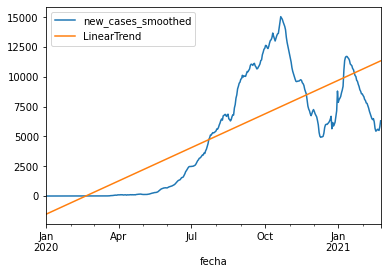

In [54]:
Arg_train.plot(kind = "line", y = ['new_cases_smoothed',"LinearTrend"], x='fecha');

In [55]:
Arg_test["LinearTrend"] = model_linear.predict(Arg_test.timeIndex)

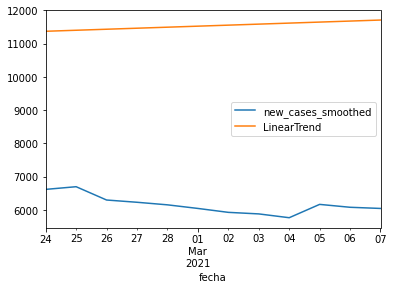

In [56]:
Arg_test.plot(kind = "line", y = ["new_cases_smoothed","LinearTrend"],x='fecha');

In [57]:
Arg_Results.loc[2, "Model"] = "LinearTrend"
Arg_Results.loc[2, "RMSE"] = RMSE(Arg_test.LinearTrend, Arg_test.new_cases_smoothed)
Arg_Results

,Model,RMSE
0,Mean,416.096
1,Random Walk,308.226
2,LinearTrend,5397.78


Ahora seguimos con un modelo de Tendencia Cuadrática:

In [58]:
model_quadratic = smf.ols('new_cases_smoothed ~ timeIndex + timeIndex_sq', data = Arg_train).fit()

In [59]:
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     new_cases_smoothed   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     424.4
Date:                Tue, 16 Mar 2021   Prob (F-statistic):          2.83e-101
Time:                        22:11:36   Log-Likelihood:                -3909.2
No. Observations:                 420   AIC:                             7824.
Df Residuals:                     417   BIC:                             7836.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3248.4007    389.903     -8.331      0.000   -4014.820   -2481.981
timeIndex       55.3180      4.299     12.869      0.000      46.868      63.768
timeIndex_sq    -0.0587      0.010     -5.909      0.000      -0.078      -0.039
==============================================================================
Omnibus:                       30.499   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.388
Skew:                           0.591   Prob(JB):                     4.16e-07
Kurtosis:                       2.468   Cond. No.                     2.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
Arg_train["QuadraticTrend"] = model_quadratic.predict(Arg_train[["timeIndex",\
                                                      "timeIndex_sq"]])

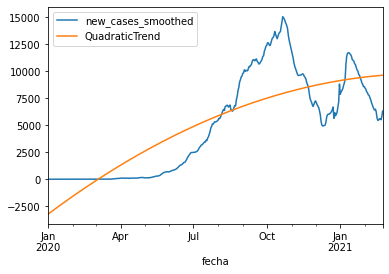

In [61]:
Arg_train.plot(kind = "line", y = ["new_cases_smoothed","QuadraticTrend"], x='fecha');

In [62]:
Arg_test["QuadraticTrend"] = model_quadratic.predict(Arg_test[["timeIndex",\
                                                      "timeIndex_sq"]])

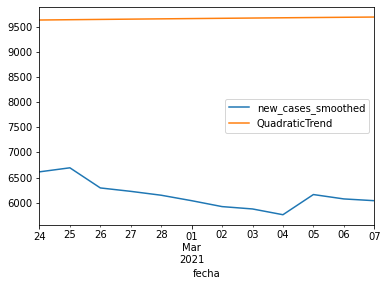

In [63]:
Arg_test.plot(kind = "line", y = ["new_cases_smoothed", "QuadraticTrend"],x='fecha');

In [64]:
Arg_Results.loc[3, "Model"] = "QuadraticTrend"
Arg_Results.loc[3, "RMSE"] = RMSE(Arg_test.QuadraticTrend, Arg_test.new_cases_smoothed)
Arg_Results

,Model,RMSE
0,Mean,416.096
1,Random Walk,308.226
2,LinearTrend,5397.78
3,QuadraticTrend,3521.38


In [112]:
Seguimos con un un modelo logaritmico:

SyntaxError: ignored

In [66]:
Arg_train['log_new_cases_smoothed'] = np.log(Arg_train['new_cases_smoothed'])
Arg_test['log_new_cases_smoothed'] = np.log(Arg_test['new_cases_smoothed'])

Arg_train['log_new_cases_smoothed'].astype(str)
Arg_train['log_new_cases_smoothed']=Arg_train['log_new_cases_smoothed'].replace(to_replace=Arg_train['log_new_cases_smoothed'][2628],value=0)
Arg_train['log_new_cases_smoothed'].astype('float64')

2628    0.000000
2629    0.000000
2630    0.000000
2631    0.000000
2632    0.000000
          ...   
3043    8.630139
3044    8.627251
3045    8.613438
3046    8.667926
3047    8.749846
Name: log_new_cases_smoothed, Length: 420, dtype: float64

In [67]:
for x in range(len(Arg_train['log_new_cases_smoothed'])-1):
    if Arg_train['log_new_cases_smoothed'].iloc[x]==0 and x==0:
        Arg_train['log_new_cases_smoothed'].iloc[x]=0
    else:
        Arg_train['log_new_cases_smoothed'].iloc[x]=(Arg_train['log_new_cases_smoothed'].iloc[x-1]+Arg_train['log_new_cases_smoothed'].iloc[x+1])/2
Arg_train['log_new_cases_smoothed']

2628    0.000000
2629    0.000000
2630    0.000000
2631    0.000000
2632    0.000000
          ...   
3043    8.629052
3044    8.621245
3045    8.644585
3046    8.697216
3047    8.749846
Name: log_new_cases_smoothed, Length: 420, dtype: float64

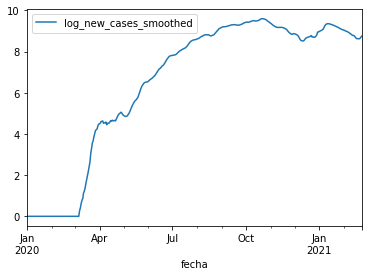

In [68]:
Arg_train.plot(kind = "line",y='log_new_cases_smoothed',x='fecha')

In [69]:
#df = df[['a', 'y', 'b', 'x']]
Arg_train =  Arg_train[['fecha', 'log_new_cases_smoothed','new_cases_smoothed', 'new_vaccinations', 'new_deaths', 'new_tests',
       'year', 'month', 'timeIndex', 'timeIndex_sq', 'Aug', 'Dec', 'Feb',
       'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Mean',
       'new_cases_smoothedShift1', 'valueDiff', 'RandomWalk', 'LinearTrend',
       'QuadraticTrend']]
Arg_train

,fecha,log_new_cases_smoothed,new_cases_smoothed,new_vaccinations,new_deaths,new_tests,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mean,new_cases_smoothedShift1,valueDiff,RandomWalk,LinearTrend,QuadraticTrend
2628,2020-01-01,0.000000,0.000,0.0,0.0,4.0,2020,Jan,0,0,0,0,0,1,0,0,0,0,0,0,0,5832.668943,1.714,-1.714,1.714,-1535.295393,-3248.400674
2629,2020-01-02,0.000000,0.000,0.0,0.0,43.0,2020,Jan,1,1,0,0,0,1,0,0,0,0,0,0,0,5832.668943,1.714,-1.714,1.714,-1504.567399,-3193.141340
2630,2020-01-03,0.000000,0.000,0.0,0.0,4.0,2020,Jan,2,4,0,0,0,1,0,0,0,0,0,0,0,5832.668943,1.714,-1.714,1.714,-1473.839405,-3137.999380
2631,2020-01-04,0.000000,0.000,0.0,0.0,17.0,2020,Jan,3,9,0,0,0,1,0,0,0,0,0,0,0,5832.668943,1.714,-1.714,1.714,-1443.111410,-3082.974795
2632,2020-01-05,0.000000,0.000,0.0,0.0,10.0,2020,Jan,4,16,0,0,0,1,0,0,0,0,0,0,0,5832.668943,1.714,-1.714,1.714,-1412.383416,-3028.067585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043,2021-02-19,8.629052,5597.857,33071.0,143.0,43037.0,2021,Feb,415,172225,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5492.857,105.000,5492.857,11216.822164,9601.137996
3044,2021-02-20,8.621245,5581.714,38494.0,122.0,30978.0,2021,Feb,416,173056,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5597.857,-16.143,5597.857,11247.550158,9607.686774
3045,2021-02-21,8.644585,5505.143,13119.0,76.0,21819.0,2021,Feb,417,173889,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5581.714,-76.571,5581.714,11278.278152,9614.118177
3046,2021-02-22,8.697216,5813.429,1967.0,161.0,39782.0,2021,Feb,418,174724,0,0,1,0,0,0,0,0,0,0,0,5832.668943,5505.143,308.286,5505.143,11309.006146,9620.432205


In [70]:
model_log = smf.ols('log_new_cases_smoothed ~ timeIndex'  , data = Arg_train).fit()

In [71]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_new_cases_smoothed   R-squared:                       0.766
Model:                                OLS   Adj. R-squared:                  0.765
Method:                     Least Squares   F-statistic:                     1368.
Date:                    Tue, 16 Mar 2021   Prob (F-statistic):          6.98e-134
Time:                            22:11:37   Log-Likelihood:                -805.67
No. Observations:                     420   AIC:                             1615.
Df Residuals:                         418   BIC:                             1623.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3408      0.161      8.334      0.000       1.025       1.657
timeIndex      0.0246      0.001     36.983      0.000       0.023       0.026
==============================================================================
Omnibus:                    12809.115   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.671
Skew:                          -0.303   Prob(JB):                     8.94e-10
Kurtosis:                       1.581   Cond. No.                         483.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
Arg_train['model_log'] = model_log.predict(Arg_train[["timeIndex"]])
Arg_test['model_log'] = model_log.predict(Arg_test[["timeIndex"]])

In [73]:
Arg_train['model_log']

2628     1.340759
2629     1.365340
2630     1.389922
2631     1.414504
2632     1.439086
          ...    
3043    11.542181
3044    11.566762
3045    11.591344
3046    11.615926
3047    11.640508
Name: model_log, Length: 420, dtype: float64

In [74]:
Arg_train['back_model_log'] = np.exp(Arg_train['model_log'])
Arg_test['back_model_log'] = np.exp(Arg_test['model_log'])

In [75]:
Arg_test.head()

,fecha,new_cases_smoothed,new_vaccinations,new_deaths,new_tests,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mean,new_cases_smoothedShift1,RandomWalk,LinearTrend,QuadraticTrend,log_new_cases_smoothed,model_log,back_model_log
3048,2021-02-24,6612.429,33840.0,140.0,37953.0,2021,Feb,420,176400,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6073.857,6309.714,11370.462135,9632.708138,8.796706,11.665089,116435.095490
3049,2021-02-25,6692.857,49377.0,145.0,33343.0,2021,Feb,421,177241,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6612.429,6309.714,11401.190129,9638.670042,8.808796,11.689671,119332.741359
3050,2021-02-26,6292.429,74083.0,92.0,35520.0,2021,Feb,422,178084,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6692.857,6309.714,11431.918123,9644.514571,8.747102,11.714253,122302.499091
3051,2021-02-27,6224.571,80980.0,59.0,27224.0,2021,Feb,423,178929,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6292.429,6309.714,11462.646117,9650.241725,8.736260,11.738834,125346.163288
3052,2021-02-28,6147.286,40108.0,19.0,22141.0,2021,Feb,424,179776,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6224.571,6309.714,11493.374111,9655.851504,8.723766,11.763416,128465.573211


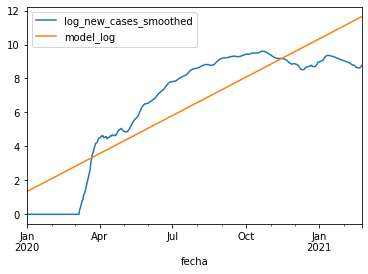

In [76]:
Arg_train.plot(kind = "line", y = ['log_new_cases_smoothed', 'model_log'],x='fecha');

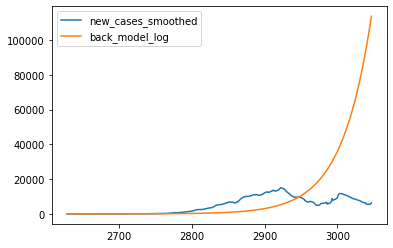

In [77]:
Arg_train.plot(kind = "line", y = ['new_cases_smoothed', 'back_model_log']);

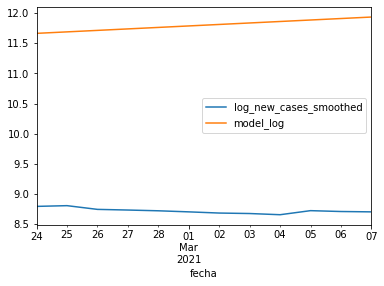

In [78]:
Arg_test.plot(kind = "line", y = ['log_new_cases_smoothed', 'model_log'],x='fecha');

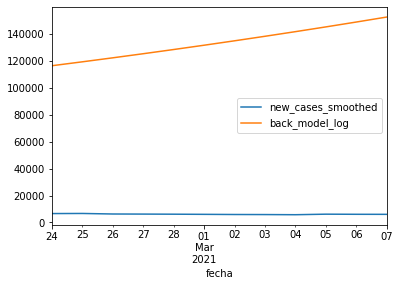

In [79]:
Arg_test.plot(kind = "line", y = ['new_cases_smoothed', 'back_model_log'],x='fecha');

Le agregamos estacionalidad mensual a la transformación logarítmica:

In [80]:
model_log_est = smf.ols('log_new_cases_smoothed ~ timeIndex + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = Arg_train).fit()

In [81]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_new_cases_smoothed   R-squared:                       0.983
Model:                                OLS   Adj. R-squared:                  0.983
Method:                     Least Squares   F-statistic:                     2019.
Date:                    Tue, 16 Mar 2021   Prob (F-statistic):               0.00
Time:                            22:11:38   Log-Likelihood:                -248.96
No. Observations:                     420   AIC:                             523.9
Df Residuals:                         407   BIC:                             576.5
Df Model:                              12                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0748      0.085     24.503      0.000       1.908       2.241
timeIndex      0.0248      0.000    108.487      0.000       0.024       0.025
Aug            1.1196      0.117      9.548      0.000       0.889       1.350
Dec           -2.0240      0.127    -15.961      0.000      -2.273      -1.775
Feb           -3.2665      0.104    -31.267      0.000      -3.472      -3.061
Jan           -2.3775      0.101    -23.512      0.000      -2.576      -2.179
Jul            1.2438      0.116     10.743      0.000       1.016       1.471
Jun            0.9824      0.116      8.495      0.000       0.755       1.210
Mar           -1.9210      0.114    -16.837      0.000      -2.145      -1.697
May            0.2198      0.114      1.927      0.055      -0.004       0.444
Nov           -0.8689      0.125     -6.964      0.000      -1.114      -0.624
Oct            0.2738      0.121      2.257      0.025       0.035       0.512
Sep            0.8107      0.120      6.756      0.000       0.575       1.047
==============================================================================
Omnibus:                       88.777   Durbin-Watson:                   0.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1189.852
Skew:                           0.436   Prob(JB):                    4.23e-259
Kurtosis:                      11.199   Cond. No.                     3.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [82]:
Arg_train['model_log_est'] = model_log_est.predict(Arg_train[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


Arg_test['model_log_est'] = model_log_est.predict(Arg_test[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])

In [83]:
Arg_train['back_model_log_est'] = np.exp(Arg_train['model_log_est'])
Arg_test['back_model_log_est'] = np.exp(Arg_test['model_log_est'])

In [84]:
Arg_test.head()

,fecha,new_cases_smoothed,new_vaccinations,new_deaths,new_tests,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mean,new_cases_smoothedShift1,RandomWalk,LinearTrend,QuadraticTrend,log_new_cases_smoothed,model_log,back_model_log,model_log_est,back_model_log_est
3048,2021-02-24,6612.429,33840.0,140.0,37953.0,2021,Feb,420,176400,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6073.857,6309.714,11370.462135,9632.708138,8.796706,11.665089,116435.095490,9.204078,9937.575569
3049,2021-02-25,6692.857,49377.0,145.0,33343.0,2021,Feb,421,177241,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6612.429,6309.714,11401.190129,9638.670042,8.808796,11.689671,119332.741359,9.228830,10186.618027
3050,2021-02-26,6292.429,74083.0,92.0,35520.0,2021,Feb,422,178084,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6692.857,6309.714,11431.918123,9644.514571,8.747102,11.714253,122302.499091,9.253582,10441.901659
3051,2021-02-27,6224.571,80980.0,59.0,27224.0,2021,Feb,423,178929,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6292.429,6309.714,11462.646117,9650.241725,8.736260,11.738834,125346.163288,9.278334,10703.582874
3052,2021-02-28,6147.286,40108.0,19.0,22141.0,2021,Feb,424,179776,0,0,1,0,0,0,0,0,0,0,0,5832.668943,6224.571,6309.714,11493.374111,9655.851504,8.723766,11.763416,128465.573211,9.303086,10971.822000


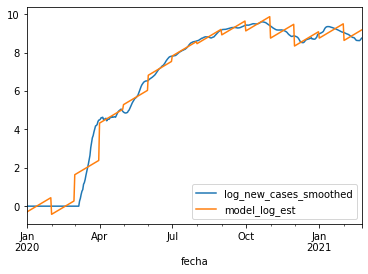

In [85]:
Arg_train.plot(kind = "line", y = ['log_new_cases_smoothed', 'model_log_est'],x='fecha');

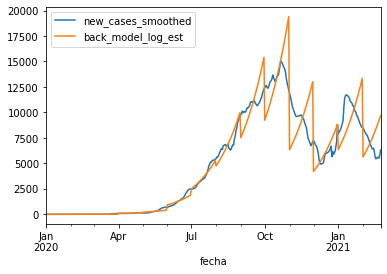

In [86]:
Arg_train.plot(kind = "line", y = ['new_cases_smoothed', 'back_model_log_est'],x='fecha');

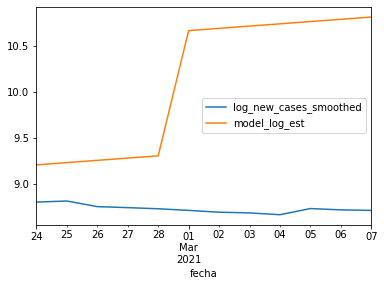

In [87]:
Arg_test.plot(kind = "line", y = ['log_new_cases_smoothed', 'model_log_est'],x='fecha');

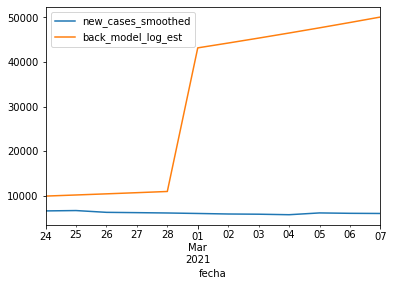

In [88]:
Arg_test.plot(kind = "line", y = ['new_cases_smoothed', 'back_model_log_est'],x='fecha');

In [89]:
Arg_Results.loc[5, "Model"] = "Transf Log + est"
Arg_Results.loc[5, "RMSE"] = RMSE(Arg_test['back_model_log_est'], Arg_test['new_cases_smoothed'])
Arg_Results

,Model,RMSE
0,Mean,416.096
1,Random Walk,308.226
2,LinearTrend,5397.78
3,QuadraticTrend,3521.38
5,Transf Log + est,31163.5


Graficamos las mejores estimaciones:

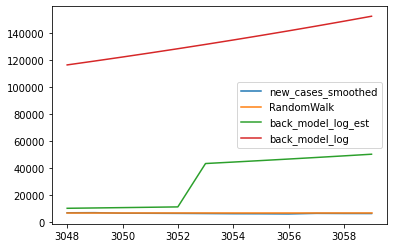

In [90]:

Arg_test.plot(kind = "line", y = ["new_cases_smoothed","RandomWalk", "back_model_log_est",\
                                                 "back_model_log"]);

Aplicamos ARIMA al modelo Random Walk que fue el mejor puntuado:

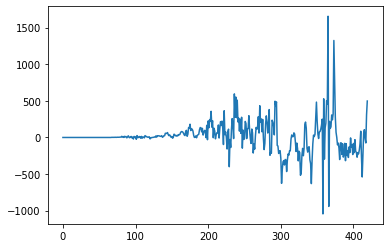

In [91]:

res_model = Arg_train['new_cases_smoothed'] - Arg_train['RandomWalk']

plt.plot(Arg_train.timeIndex, res_model, '-');

In [92]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -3.642247
p-value: 0.005003
Valor crítico 1%: -3.45
Valor crítico 5%: -2.87
Valor crítico 10%: -2.57


In [93]:
#4.2- Modelo ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [94]:
lag_acf = acf(res_model, nlags = 20)
lag_acf

array([ 1.        ,  0.38327524,  0.4214269 ,  0.2673192 ,  0.27589261,
        0.16892726,  0.19939142, -0.13340187,  0.23263989,  0.12478472,
        0.15213326,  0.09597173,  0.08438222,  0.048071  ,  0.1298109 ,
        0.08230192,  0.09189956,  0.05330853,  0.08940789,  0.06287094,
        0.06795209])

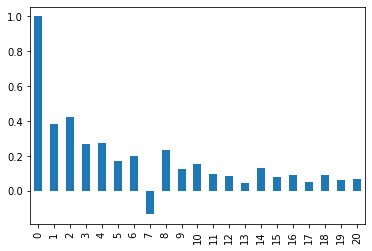

In [95]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

In [96]:
lag_pacf = pacf(res_model, nlags=20, method='ols');

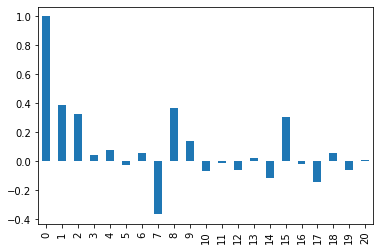

In [97]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

In [98]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

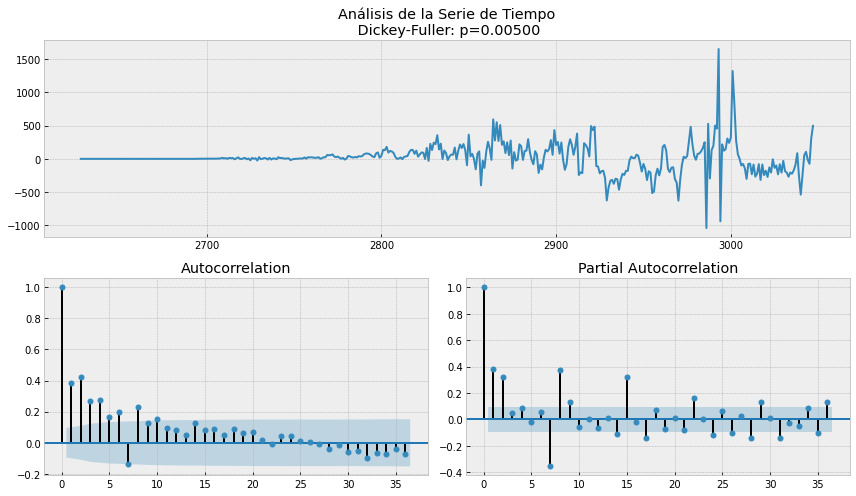

In [99]:
tsplot(res_model, lags=36)

In [100]:
from statsmodels.tsa.arima_model import ARIMA

In [101]:
model_ARIMA = ARIMA(res_model, order=(3,0,3))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

2628    16.980786
2629     9.417021
2630     5.890369
2631     6.159190
2632     6.116509
dtype: float64

In [102]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  420
Model:                     ARMA(3, 3)   Log Likelihood               -2763.111
Method:                       css-mle   S.D. of innovations            173.573
Date:                Tue, 16 Mar 2021   AIC                           5542.221
Time:                        22:11:42   BIC                           5574.543
Sample:                             0   HQIC                          5554.996
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.9808     26.179      0.649      0.517     -34.329      68.290
ar.L1.y        0.4777      0.088      5.413      0.000       0.305       0.651
ar.L2.y       -0.2956      0.056     -5.321      0.0

Observamos que los p-value son  menores a 0.05 en todos los casos.

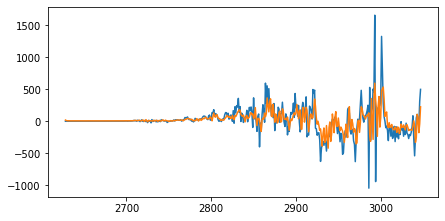

In [103]:
plt.figure(figsize=(7,3.5))
res_model.plot()
results_ARIMA.fittedvalues.plot();

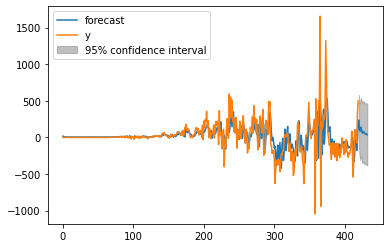

In [104]:
results_ARIMA.plot_predict(end=len(Arg['new_cases_smoothed']));

In [105]:
res_ARIMA =  results_ARIMA.fittedvalues - res_model

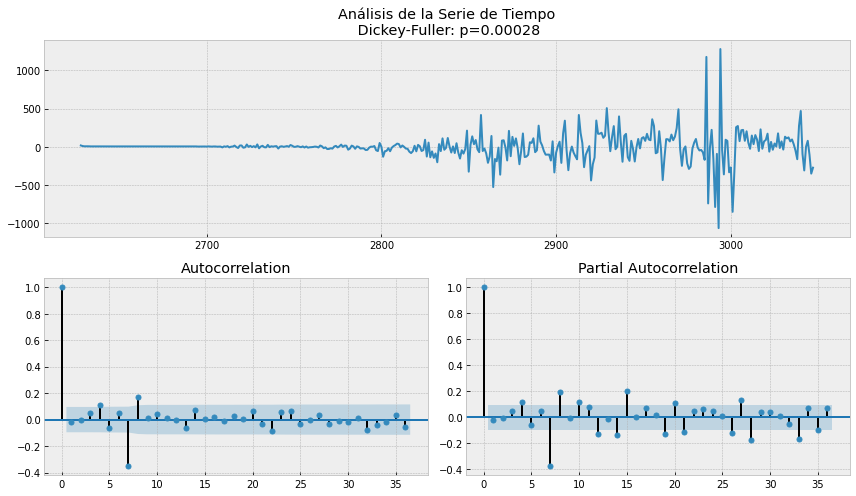

In [106]:
tsplot(res_ARIMA, lags=36)

In [107]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(Arg_test['new_cases_smoothed']), alpha=0.05)

In [108]:
Arg_train['RandomWalk_ARIMA'] = Arg_train['RandomWalk'] + results_ARIMA.fittedvalues

Arg_test['RandomWalk_ARIMA'] = Arg_test['RandomWalk'] + predictions_ARIMA

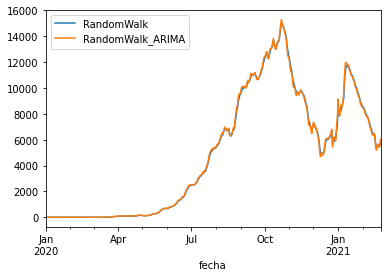

In [109]:
Arg_train.plot(kind = "line", y = ['RandomWalk', 'RandomWalk_ARIMA'],x='fecha');

Finalmente graficmos los valores reales de nuevos casos y Random Walk con y sin ARIMA. Al final de la notebook presentamos una tabla con los errores cuadraticos medios para cada modelo:

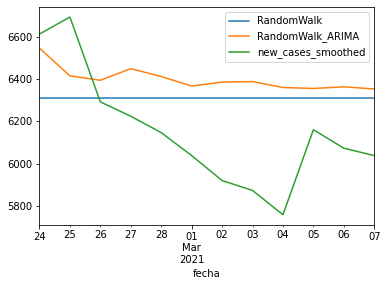

In [110]:
Arg_test.plot(kind = "line", y = ['RandomWalk', 'RandomWalk_ARIMA','new_cases_smoothed'],x='fecha');

In [111]:
Arg_Results.loc[7, "Model"] = "Random Walk + ARIMA"
Arg_Results.loc[7, "RMSE"] = RMSE(Arg_test['RandomWalk_ARIMA'], Arg_test['new_cases_smoothed'])
Arg_Results

,Model,RMSE
0,Mean,416.096
1,Random Walk,308.226
2,LinearTrend,5397.78
3,QuadraticTrend,3521.38
5,Transf Log + est,31163.5
7,Random Walk + ARIMA,339.333
